In [1]:
"""
AMPERE: A Generic Energy Estimation Approach for On-Device Training
Implementation for Google Colab

Paper: https://intellisys.haow.us/assets/pdf/AMPERE.pdf
"""

'\nAMPERE: A Generic Energy Estimation Approach for On-Device Training\nImplementation for Google Colab\n\nPaper: https://intellisys.haow.us/assets/pdf/AMPERE.pdf\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [ ]:
# Gaussian Process with Matérn kernel (Equation 3)
class GaussianProcess:
    def __init__(self, length_scale=10.0, noise=0.01):
        self.length_scale = length_scale
        self.noise = noise
        self.X_train = None
        self.y_train = None
        self.K_inv = None

    def matern_kernel(self, X1, X2):
        """Matérn kernel (ν=2.5): k(x_i, x_j) = (1 + √5·d/l + 5·d²/3l²)·exp(-√5·d/l)"""
        dists = cdist(X1.reshape(-1, 1), X2.reshape(-1, 1))
        dists = np.sqrt(5) * dists / self.length_scale
        return (1 + dists + dists**2 / 3.0) * np.exp(-dists)

    def fit(self, X, y):
        """Fitting GP to training data"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        K = self.matern_kernel(self.X_train, self.X_train)
        K += self.noise * np.eye(len(X))
        self.K_inv = np.linalg.inv(K + 0.1 * np.eye(len(X)))  # Adding stability

    def predict(self, X):
        """Predicting mean and variance"""
        if self.X_train is None:
            return np.zeros(len(X)), np.ones(len(X))

        X = np.array(X)
        K_s = self.matern_kernel(self.X_train, X)
        K_ss = self.matern_kernel(X, X)

        mean = K_s.T @ self.K_inv @ self.y_train
        v = self.K_inv @ K_s
        variance = np.maximum(np.diag(K_ss) - np.sum(K_s * v, axis=0), 0)

        return mean, variance


In [ ]:
# Simulating energy measurement (replace with real power meter in deployment)
def measure_energy(layer_type, cin=None, cout=None, input_size=28, batch_size=32):
    """Simulating energy measurement for a layer configuration"""
    if layer_type == 'input':
        base, scale = 2.0, 0.15 * cout + 0.02 * (cout ** 2) / 50
    elif layer_type == 'output':
        base, scale = 1.5, 0.12 * cin + 0.015 * (cin ** 2) / 50
    elif layer_type == 'hidden':
        base = 1.0
        scale = 0.08 * cin + 0.08 * cout + 0.005 * (cin * cout) / 100
    else:
        raise ValueError(f"Unknown layer type: {layer_type}")

    size_factor = (input_size / 28) ** 2
    energy = (base + scale) * size_factor * (batch_size / 32)
    noise = energy * 0.05 * (np.random.random() - 0.5)

    return max(0.1, energy + noise)


In [ ]:
# AMPERE: Main framework
class AMPERE:
    def __init__(self, max_steps=8, channel_range=(8, 128)):
        self.max_steps = max_steps
        self.channel_range = channel_range
        self.gps = {'input': GaussianProcess(), 'hidden': GaussianProcess(), 'output': GaussianProcess()}
        self.data = {'input': {'X': [], 'y': []}, 'hidden': {'X': [], 'y': []}, 'output': {'X': [], 'y': []}}

    def profile_and_fit(self, input_size=28, batch_size=32, verbose=True):
        """Profiling layers using guided sampling (Section 3.2 & 3.3)"""
        if verbose:
            print("AMPERE Profiling")

        # Profiling each layer type
        for layer_type in ['output', 'input', 'hidden']:
            if verbose:
                print(f"\n{layer_type.upper()}:")
            X_data, y_data = [], []
            candidates = np.linspace(self.channel_range[0], self.channel_range[1], 50)

            # Guided profiling with GP uncertainty
            for step in range(self.max_steps):
                # Selecting next point: boundaries first, then max variance
                if step < 2:
                    next_ch = self.channel_range[step]
                else:
                    _, variances = self.gps[layer_type].predict(candidates)
                    next_ch = candidates[np.argmax(variances)]

                # Measuring energy with subtractivity (Equations 1 & 2)
                if layer_type == 'output':
                    energy = measure_energy('output', cin=next_ch, cout=10, input_size=input_size, batch_size=batch_size)
                elif layer_type == 'input':
                    total = measure_energy('input', cin=3, cout=next_ch, input_size=input_size, batch_size=batch_size)
                    output_e, _ = self.gps['output'].predict([next_ch])
                    energy = total - output_e[0]
                else:  # hidden
                    energy = measure_energy('hidden', cin=next_ch, cout=next_ch, input_size=input_size, batch_size=batch_size)

                X_data.append(next_ch)
                y_data.append(energy)
                self.gps[layer_type].fit(X_data, y_data)

                if verbose:
                    print(f"  Step {step+1}: ch={int(next_ch)}, E={energy:.2f}J")

                # Early stopping
                _, variances = self.gps[layer_type].predict(candidates)
                if np.max(variances) < 0.05 * np.mean(y_data):
                    if verbose:
                        print(f"  Early stop: low variance")
                    break

            self.data[layer_type] = {'X': X_data, 'y': y_data}

    def estimate_energy(self, input_ch, hidden_layers, output_ch=10):
        """Estimating total energy for a model (Equation 4)"""
        # Input layer
        input_e, _ = self.gps['input'].predict([input_ch])
        input_e = input_e[0]

        # Hidden layers
        hidden_e = []
        for cin, cout in hidden_layers:
            base_e, _ = self.gps['hidden'].predict([64])
            scale = (cin + cout) / 128
            hidden_e.append(base_e[0] * scale)

        # Output layer
        last_ch = hidden_layers[-1][1] if hidden_layers else input_ch
        output_e, _ = self.gps['output'].predict([last_ch])
        output_e = output_e[0]

        total = input_e + sum(hidden_e) + output_e

        return {
            'total': total,
            'input': input_e,
            'hidden': hidden_e,
            'output': output_e
        }

    def visualize(self, layer_type):
        """Visualizing GP fit"""
        data = self.data[layer_type]
        if not data['X']:
            return

        X_plot = np.linspace(self.channel_range[0], self.channel_range[1], 100)
        mean, var = self.gps[layer_type].predict(X_plot)
        std = np.sqrt(var)

        plt.figure(figsize=(10, 4))
        plt.plot(X_plot, mean, 'b-', label='GP Mean', linewidth=2)
        plt.fill_between(X_plot, mean - 2*std, mean + 2*std, alpha=0.3, label='95% CI')
        plt.scatter(data['X'], data['y'], c='red', s=100, zorder=5, label='Profiled')
        plt.xlabel('Channels')
        plt.ylabel('Energy (J)')
        plt.title(f'{layer_type.capitalize()} Layer')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


AMPERE Profiling

OUTPUT:
  Step 1: ch=8, E=2.46J
  Step 2: ch=128, E=22.27J
  Step 3: ch=66, E=10.98J
  Step 4: ch=98, E=16.33J
  Step 5: ch=37, E=6.30J
  Step 6: ch=83, E=13.45J
  Step 7: ch=22, E=4.28J
  Step 8: ch=113, E=19.30J

INPUT:
  Step 1: ch=8, E=0.94J
  Step 2: ch=128, E=7.66J
  Step 3: ch=66, E=3.38J
  Step 4: ch=98, E=5.86J
  Step 5: ch=37, E=2.54J
  Step 6: ch=83, E=4.56J
  Step 7: ch=22, E=1.48J
  Step 8: ch=113, E=5.57J

HIDDEN:
  Step 1: ch=8, E=2.26J
  Step 2: ch=128, E=22.33J
  Step 3: ch=66, E=11.87J
  Step 4: ch=98, E=17.08J
  Step 5: ch=37, E=7.09J
  Step 6: ch=83, E=14.51J
  Step 7: ch=22, E=4.61J
  Step 8: ch=113, E=19.64J

GP Model Fits:


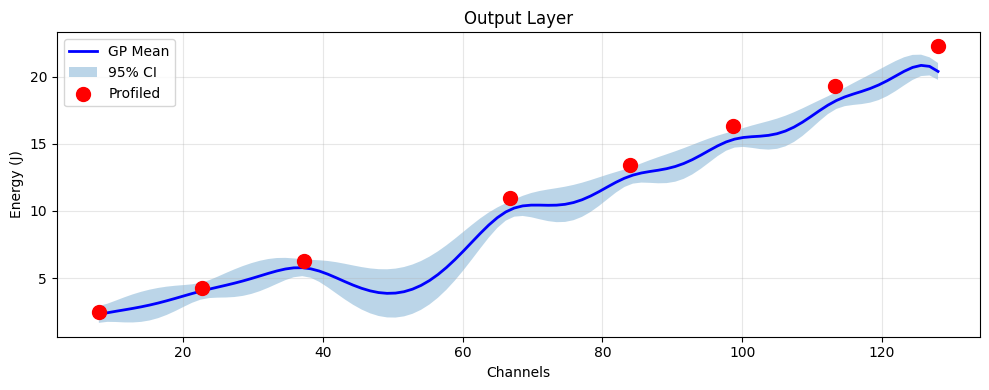

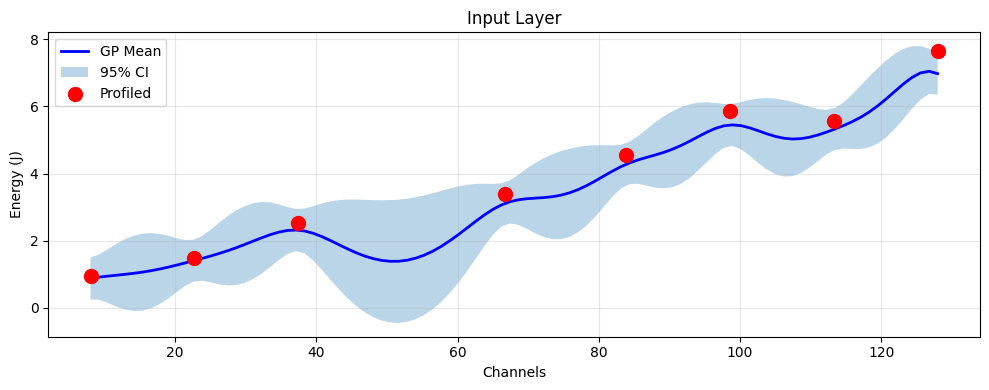

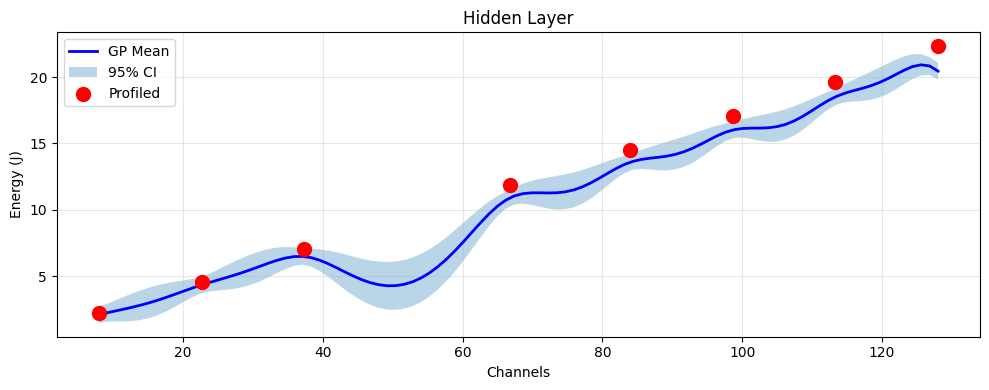


Energy Estimation:

Small CNN: 28.30J (input: 2.07J, hidden: 17.17J, output: 9.07J)

Medium CNN: 60.91J (input: 2.80J, hidden: 49.04J, output: 9.07J)

Large CNN: 128.85J (input: 6.98J, hidden: 112.80J, output: 9.07J)


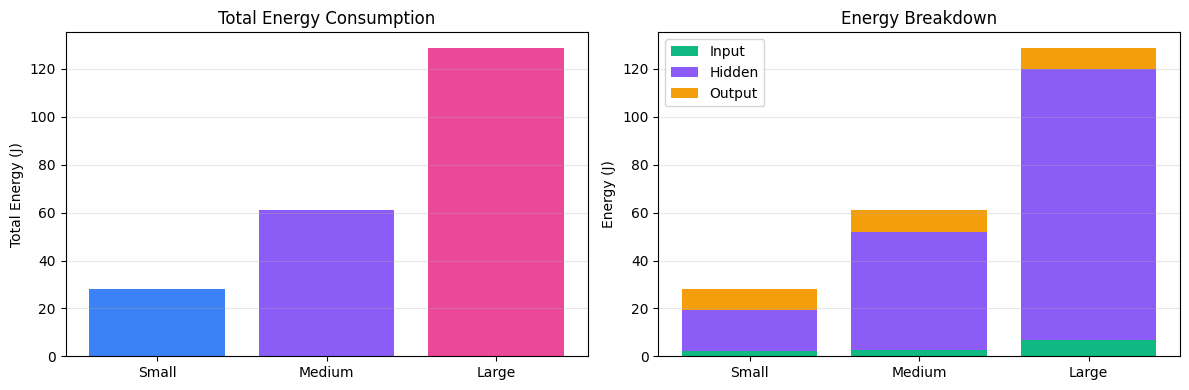

In [ ]:
# Demo
np.random.seed(42)

# Initializing and profiling
ampere = AMPERE(max_steps=8, channel_range=(8, 128))
ampere.profile_and_fit(input_size=28, batch_size=32)

# Visualizing GP fits
print("\nGP Model Fits:")
for layer in ['output', 'input', 'hidden']:
    ampere.visualize(layer)

# Testing different model configurations
print("\nEnergy Estimation:")
models = [
    ('Small', 32, [(32, 64), (64, 64)]),
    ('Medium', 64, [(64, 128), (128, 128), (128, 64)]),
    ('Large', 128, [(128, 256), (256, 256), (256, 128), (128, 64)])
]

results = []
for name, input_ch, hidden in models:
    result = ampere.estimate_energy(input_ch, hidden)
    results.append(result)
    print(f"\n{name} CNN: {result['total']:.2f}J (input: {result['input']:.2f}J, hidden: {sum(result['hidden']):.2f}J, output: {result['output']:.2f}J)")

# Comparing models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Total energy
names = [m[0] for m in models]
totals = [r['total'] for r in results]
ax1.bar(names, totals, color=['#3b82f6', '#8b5cf6', '#ec4899'])
ax1.set_ylabel('Total Energy (J)')
ax1.set_title('Total Energy Consumption')
ax1.grid(axis='y', alpha=0.3)

# Breakdown
inputs = [r['input'] for r in results]
hiddens = [sum(r['hidden']) for r in results]
outputs = [r['output'] for r in results]

x = np.arange(len(names))
ax2.bar(x, inputs, label='Input', color='#10b981')
ax2.bar(x, hiddens, bottom=inputs, label='Hidden', color='#8b5cf6')
ax2.bar(x, outputs, bottom=np.array(inputs)+np.array(hiddens), label='Output', color='#f59e0b')

ax2.set_xticks(x)
ax2.set_xticklabels(names)
ax2.set_ylabel('Energy (J)')
ax2.set_title('Energy Breakdown')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Improving AMPERE with more profiling steps